In [1]:
# Scientific libraries
import numpy_html
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike') 
jtplot.style(context='notebook', fscale=1, grid=False)
#import seaborn as sns

#optional 3ML imports

#from threeML import *
#from astromodels.xspec.xspec_settings import *
#from astromodels.xspec.factory import *

#useful libraries

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

import pystan
import stan_utility


import multiprocessing

In [2]:
class Rebinner(object):
    """
    A class to rebin vectors keeping a minimum value per bin. It supports array with a mask, so that elements excluded
    through the mask will not be considered for the rebinning
    """

    def __init__(self, vector_to_rebin_on, min_value_per_bin, mask=None):

        # Basic check that it is possible to do what we have been requested to do

        total = np.sum(vector_to_rebin_on)

        if total < min_value_per_bin:
            raise NotEnoughData("Vector total is %s, cannot rebin at %s per bin" % (total, min_value_per_bin))

        # Check if we have a mask, if not prepare a empty one
        if mask is not None:

            mask = np.array(mask, bool)

            assert mask.shape[0] == len(vector_to_rebin_on), "The provided mask must have the same number of " \
                                                             "elements as the vector to rebin on"

        else:

            mask = np.ones_like(vector_to_rebin_on, dtype=bool)

        self._mask = mask

        # Rebin taking the mask into account

        self._starts = []
        self._stops = []
        self._grouping = np.zeros_like(vector_to_rebin_on)

        n = 0
        bin_open = False

        n_grouped_bins = 0

        for index, b in enumerate(vector_to_rebin_on):

            if not mask[index]:

                # This element is excluded by the mask

                if not bin_open:

                    # Do nothing
                    continue

                else:

                    # We need to close the bin here
                    self._stops.append(index)
                    n = 0
                    bin_open = False

                    # If we have grouped more than one bin

                    if n_grouped_bins > 1:

                        # group all these bins
                        self._grouping[index - n_grouped_bins + 1: index] = -1
                        self._grouping[index] = 1

                    # reset the number of bins in this group

                    n_grouped_bins = 0

            else:

                # This element is included by the mask

                if not bin_open:
                    # Open a new bin
                    bin_open = True

                    self._starts.append(index)
                    n = 0

                # Add the current value to the open bin

                n += b

                n_grouped_bins += 1

                # If we are beyond the requested value, close the bin

                if n >= min_value_per_bin:
                    self._stops.append(index + 1)

                    n = 0

                    bin_open = False

                    # If we have grouped more than one bin

                    if n_grouped_bins > 1:

                        # group all these bins
                        self._grouping[index - n_grouped_bins + 1: index] = -1
                        self._grouping[index] = 1

                    # reset the number of bins in this group

                    n_grouped_bins = 0

        # At the end of the loop, see if we left a bin open, if we did, close it

        if bin_open:
            self._stops.append(len(vector_to_rebin_on))

        assert len(self._starts) == len(self._stops), "This is a bug: the starts and stops of the bins are not in " \
                                                      "equal number"

        self._min_value_per_bin = min_value_per_bin

    @property
    def n_bins(self):
        """
        Returns the number of bins defined.
        :return:
        """

        return len(self._starts)

    @property
    def grouping(self):

        return self._grouping

    def rebin(self, *vectors):

        rebinned_vectors = []

        for vector in vectors:

            assert len(vector) == len(self._mask), "The vector to rebin must have the same number of elements of the" \
                                                   "original (not-rebinned) vector"

            # Transform in array because we need to use the mask
            vector_a = np.array(vector)

            rebinned_vector = []

            for low_bound, hi_bound in zip(self._starts, self._stops):

                rebinned_vector.append(np.sum(vector_a[low_bound:hi_bound]))

            # Vector might not contain counts, so we use a relative comparison to check that we didn't miss
            # anything.
            # NOTE: we add 1e-100 because if both rebinned_vector and vector_a contains only 0, the check would
            # fail when it shouldn't

            assert abs((np.sum(rebinned_vector) + 1e-100) / (np.sum(vector_a[self._mask]) + 1e-100) - 1) < 1e-4

            rebinned_vectors.append(np.array(rebinned_vector))

        return rebinned_vectors

    def rebin_errors(self, *vectors):
        """
        Rebin errors by summing the squares
        Args:
            *vectors:
        Returns:
            array of rebinned errors
        """

        rebinned_vectors = []

        for vector in vectors:  # type: np.ndarray[np.ndarray]

            assert len(vector) == len(self._mask), "The vector to rebin must have the same number of elements of the" \
                                                   "original (not-rebinned) vector"

            rebinned_vector = []

            for low_bound, hi_bound in zip(self._starts, self._stops):

                rebinned_vector.append(np.sqrt(np.sum(vector[low_bound:hi_bound] ** 2)))

            rebinned_vectors.append(np.array(rebinned_vector))

        return rebinned_vectors

    def get_new_start_and_stop(self, old_start, old_stop):

        assert len(old_start) == len(self._mask) and len(old_stop) == len(self._mask)

        new_start = np.zeros(len(self._starts))
        new_stop = np.zeros(len(self._starts))

        for i, (low_bound, hi_bound) in enumerate(zip(self._starts, self._stops)):
            new_start[i] = old_start[low_bound]
            new_stop[i] = old_stop[hi_bound - 1]

        return new_start, new_stop


In [3]:
def step_plot(xbins, y, ax, fill=False, fill_min=0, **kwargs):
    '''
    Routine for plotting a in steps with the ability to fill the plot
    xbins is a 2D list of start and stop values.
    y are the values in the bins.
    '''

    if fill:

        x = []
        newy = []

        for t, v in zip(xbins, y):
            x.append(t[0])
            newy.append(v)
            x.append(t[1])
            newy.append(v)

        ax.fill_between(x, newy, fill_min, **kwargs)

    else:

        # This supports a mask, so the line will not be drawn for missing bins

        new_x = []
        new_y = []

        for (x1, x2), y in zip(xbins, y):

            if len(new_x) == 0:

                # First iteration

                new_x.append(x1)
                new_x.append(x2)
                new_y.append(y)

            else:

                if x1 == new_x[-1]:

                    # This bin is contiguous to the previous one

                    new_x.append(x2)
                    new_y.append(y)

                else:

                    # This bin is not contiguous to the previous one
                    # Add a "missing bin"
                    new_x.append(x1)
                    new_y.append(np.nan)
                    new_x.append(x2)
                    new_y.append(y)

        new_y.append(new_y[-1])

        new_y = np.ma.masked_where(~np.isfinite(new_y), new_y)

        ax.step(new_x, new_y, where='post',**kwargs)

# source only 

In [4]:
gen = stan_utility.compile_model(filename='generate_data.stan', model_name='poisson_gen' )

Using cached StanModel


In [20]:
nbins = 100;
bins = np.logspace(0,2, nbins +1)
a = bins[:-1]
b = bins[1:]

simu_K = 1.
simu_p =-2
x0 = 10.

gen_data = dict(N=nbins, a=a,b=b,K=simu_K,p=simu_p,x0=x0)

R = 10000 # 1000 draws from the Bayesian joint distribution

out = gen.sampling(data=gen_data,
                 
                   iter=R, warmup=0, chains=1, refresh=R,
                     seed=4838282, algorithm="Fixed_param"
                   
                  
                  )


sim_counts = out.extract('output')['output'].astype(int)

In [110]:

fit_model = stan_utility.compile_model(filename='fit_poisson.stan', model_name='poisson_fit' )

def analyze_simu(simu):
    
    
    # Fit the simulated observation
    
    input_data = dict(N=nbins, a=a,b=b, counts =simu,  x0=x0)
    
    fit = fit_model.sampling(data=input_data, seed=4938483, n_jobs=1)
    
    # Compute diagnostics
    warning_code = stan_utility.check_all_diagnostics(fit, quiet=True)
    
    # Compute rank of prior draw with respect to thinned posterior draws
    thinned_p = fit.extract()['p'][np.arange(0, 4000 - 7, 8)]
    sbc_rank = len(list(filter(lambda x: x > simu_p, thinned_p)))
    
    # Compute posterior sensitivities
    summary = fit.summary(probs=[0.5],pars='p')
    post_mean_p = [x[0] for x in summary['summary']][0]
    post_sd_p = [x[2] for x in summary['summary']][0]
    
    prior_sd_p = 1.
    
    z_score = (post_mean_p - simu_p) / post_sd_p
    shrinkage = 1 - (post_sd_p / prior_sd_p)**2
    
    return [warning_code, sbc_rank, z_score, shrinkage]

Using cached StanModel


In [111]:
pool = multiprocessing.Pool(4)
ensemble_output = pool.map(analyze_simu, sim_counts)

Process ForkPoolWorker-40:
Process ForkPoolWorker-38:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/Cellar/python/3.7.3/Frame

In [112]:
warning_codes = [x[0] for x in ensemble_output]
if sum(warning_codes) is not 0:
    print ("Some posterior fits in the generative " +
           "ensemble encountered problems!")
    for r in range(R):
        if warning_codes[r] is not 0:
            print('Replication {} of {}'.format(r, R))
            print('Simulated lambda = {}'.format(simu_lambdas[r]))
            stan_utility.parse_warning_code(warning_codes[r])
            print("")
else:
    print ("No posterior fits in the generative " +
           "ensemble encountered problems!")


No posterior fits in the generative ensemble encountered problems!


<IPython.core.display.Javascript object>


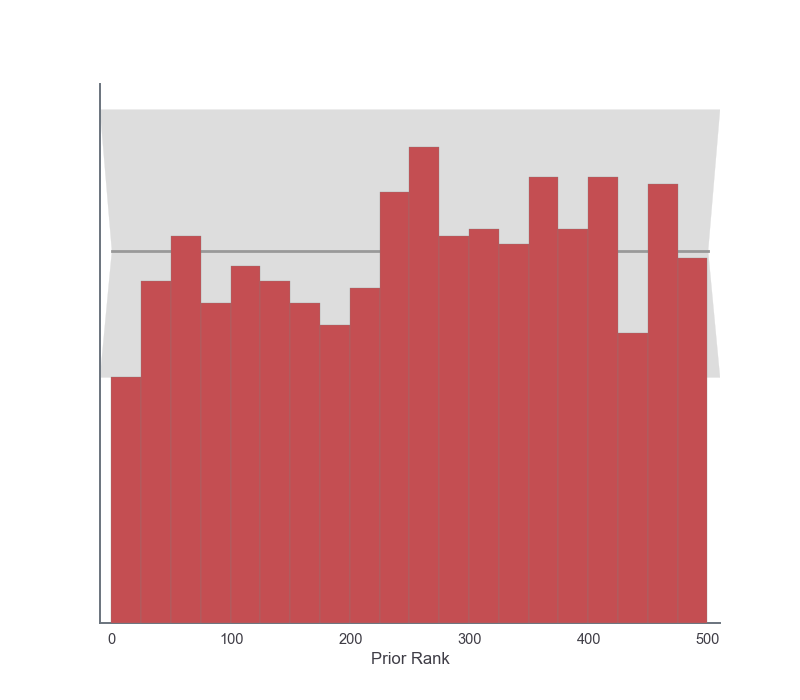

In [114]:
sbc_low = stats.binom.ppf(0.005, R, 25.0 / 500)
sbc_mid = stats.binom.ppf(0.5, R, 25.0 / 500)
sbc_high = stats.binom.ppf(0.995, R, 25.0 / 500)

bar_x = [-10, 510, 500, 510, -10, 0, -10]
bar_y = [sbc_high, sbc_high, sbc_mid, sbc_low, sbc_low, sbc_mid, sbc_high]



fig, ax = plt.subplots()
ax.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
ax.plot([0, 500], [sbc_mid, sbc_mid], color="#999999", linewidth=2)

sbc_ranks = [x[1] for x in ensemble_output]

ax.hist(sbc_ranks, bins=[25 * x - 0.5 for x in range(21)],
          color='r', ec='grey', zorder=3)

ax.set_xlabel("Prior Rank")
ax.set_xlim(-10, 510)
ax.axes.get_yaxis().set_visible(False)



<IPython.core.display.Javascript object>


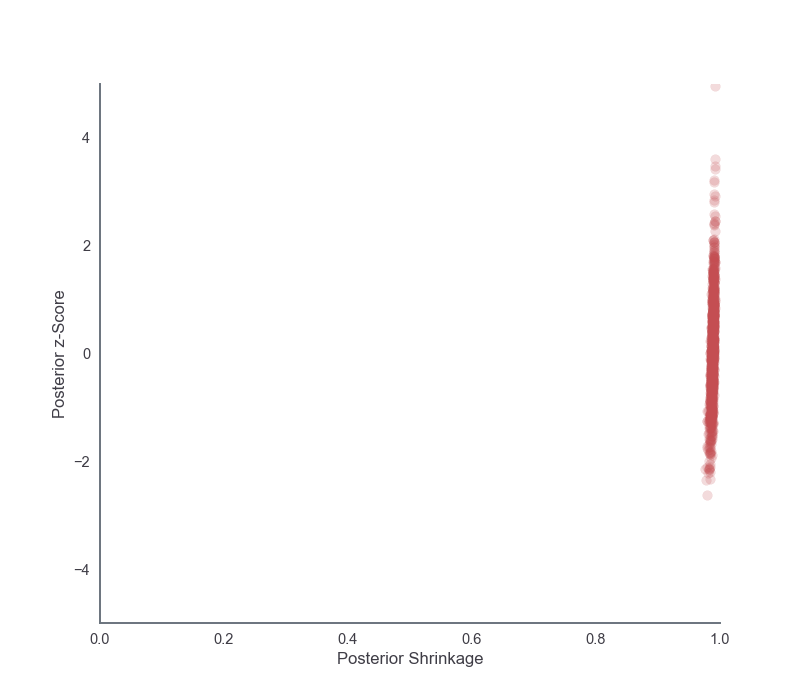

(-5, 5)

In [117]:
z_scores = [x[2] for x in ensemble_output]
shrinkages = [x[3] for x in ensemble_output]

fig, ax = plt.subplots()

ax.scatter(shrinkages, z_scores, color='r', alpha=0.2)
ax.set_xlabel("Posterior Shrinkage")
ax.set_xlim(0, 1)
ax.set_ylabel("Posterior z-Score")
ax.set_ylim(-5, 5)



<IPython.core.display.Javascript object>


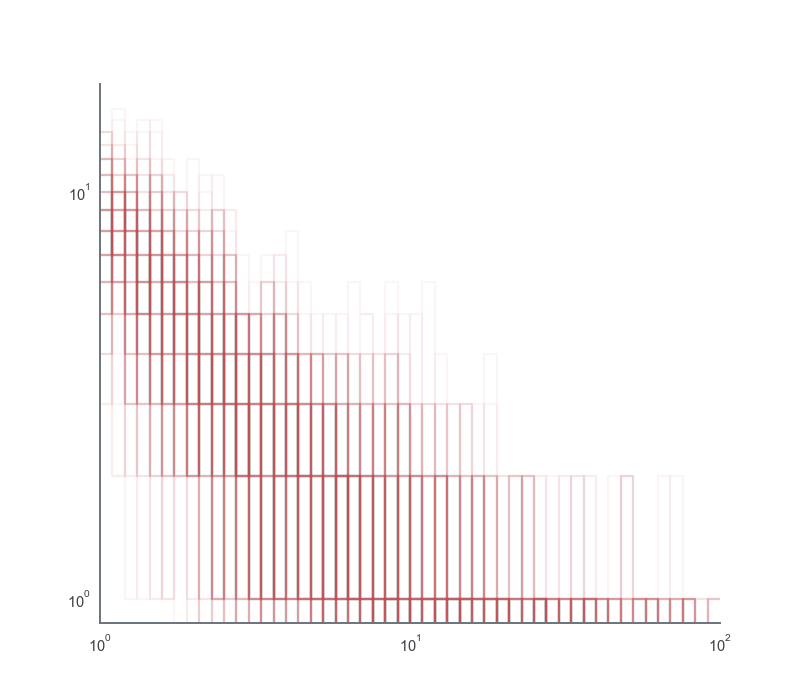

(1, 100)

In [138]:
fig, ax = plt.subplots()

for c in counts:

    step_plot(np.vstack((a,b)).T, c, ax, fill=False, fill_min=0, alpha=.05, color='r')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,100)

In [15]:
sim_counts = out.extract('output')['output'].astype(int)

model = stan_utility.compile_model(filename='fit_poisson.stan', model_name='poisson_fit' )
model_chi = stan_utility.compile_model(filename='fit_chi2.stan', model_name='chi2_fit' )

ValueError: No parameter output

In [27]:
def mle_go(counts):
    
    data = dict(N=nbins, a=a,b=b, counts =counts,  x0=x0)
    fit = model.optimizing(data=data, seed=345766723)
    
    return fit['K'], fit['p']



def init_me():
    
    return dict(log_K=0,p=-2)

def mle_chi_go(counts):
    
    
    
    binner = Rebinner(counts,20)
    rebinned_counts = binner.rebin(counts)[0]
    new_a, new_b = binner.get_new_start_and_stop(a,b)
    
    data = dict(N=binner.n_bins, a=new_a,b=new_b, counts =rebinned_counts,  x0=x0)
    #print(binner.n_bins)
    try:
        fit = model_chi.optimizing(data=data, seed=345766723, init=init_me)
    
        return fit['K'], fit['p']
    
    except:
        
        return -99, -99
    
 

In [46]:
 model.optimizing?

In [102]:
fit = fit_model.sampling(data=data, seed = 128445);

In [23]:
pool = multiprocessing.Pool(4)
ensemble_output = np.array(pool.map(mle_go , sim_counts))

pool.close()

In [28]:
pool = multiprocessing.Pool(4)
ensemble_output2 = np.array(pool.map(mle_chi_go , sim_counts))

pool.close()

<IPython.core.display.Javascript object>


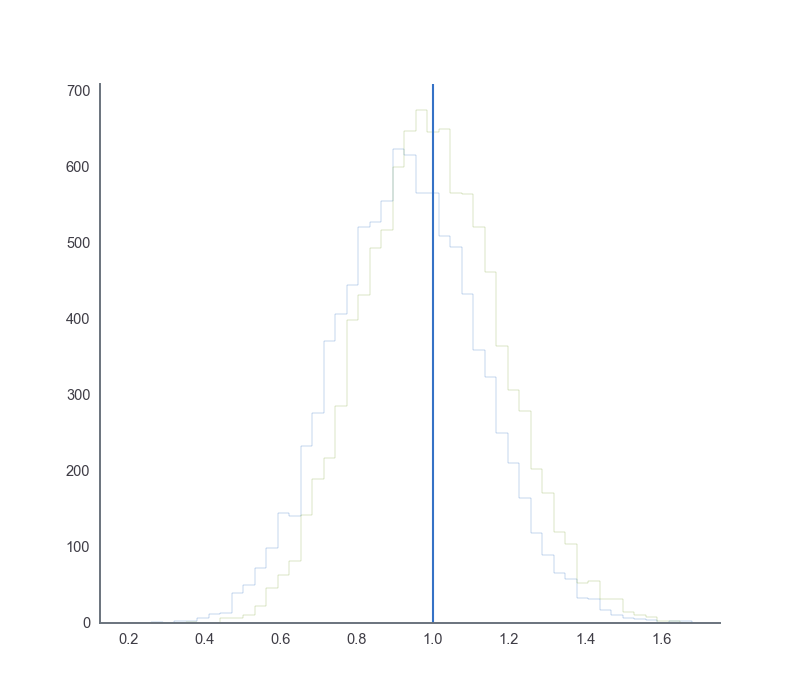

In [36]:
fig, ax = plt.subplots()

idx = ensemble_output2[:,0]==-99
bins = np.linspace(0.2,1.68,50)
ax.hist(ensemble_output2[~idx,0] ,bins=bins,histtype='step')
ax.hist(ensemble_output[:,0] ,bins=bins,histtype='step')

ax.axvline(1)

<IPython.core.display.Javascript object>


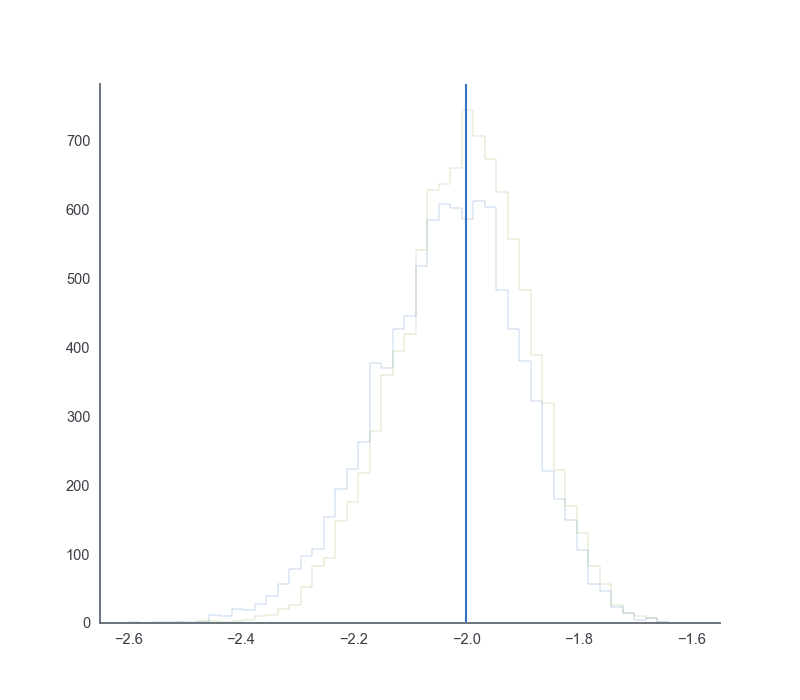

In [35]:
fig, ax = plt.subplots()

bins = np.linspace(-2.6,-1.6,50)

idx = ensemble_output2[:,1]==-99

ax.hist(ensemble_output2[~idx,1] ,bins=bins,histtype='step')
ax.hist(ensemble_output[:,1] ,bins=bins,histtype='step')

ax.axvline(-2)

In [182]:
data = dict(N=nbins, a=a,b=b, counts = sim_counts[1],  x0=x0)

#fit = fit_model.sampling(data=data, seed = 128445);

In [185]:
model.optimizing(data=data, seed=345766723)

OrderedDict([('log_K', array(-0.19703582)),
             ('p', array(-2.12793648)),
             ('K', array(0.82116122))])

<IPython.core.display.Javascript object>


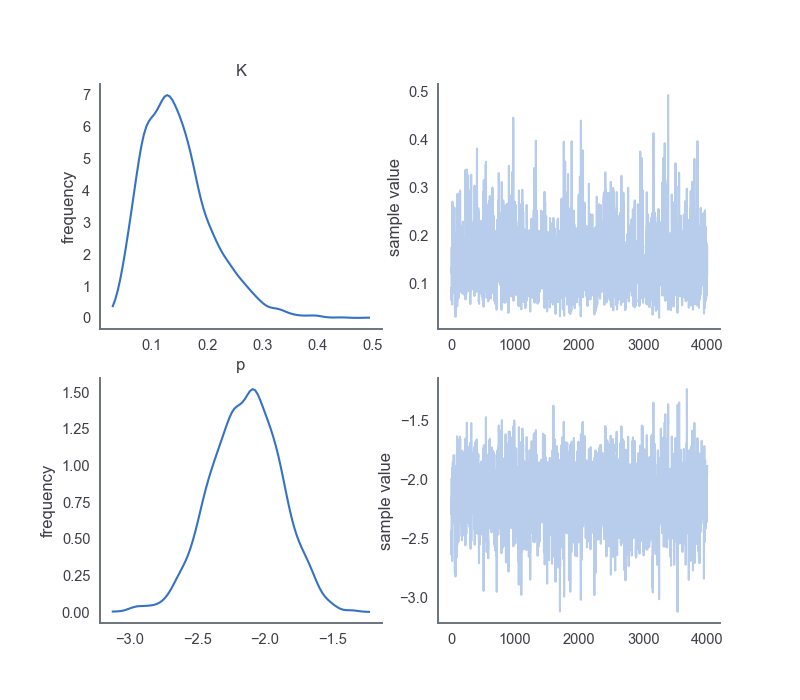

In [141]:
fit.plot(pars=['K','p']);

In [83]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [107]:
fit.summary(probs=[0.5],pars='p')['summary'].shape

(1, 6)

In [105]:
fit.summary?

In [123]:
binner.n_bins

11

In [124]:
binner.rebin(counts[0])

[array([16, 10, 11, 14, 10, 12, 11, 10, 12, 10,  1])]

(array([ 1.        ,  1.20226443,  1.31825674,  1.58489319,  1.90546072,
         2.29086765,  2.7542287 ,  3.98107171,  5.2480746 ,  7.58577575,
        33.11311215]),
 array([  1.20226443,   1.31825674,   1.58489319,   1.90546072,
          2.29086765,   2.7542287 ,   3.98107171,   5.2480746 ,
          7.58577575,  33.11311215, 100.        ]))

In [126]:
a

1.
1.0964782
1.20226443
1.31825674
1.44543977
1.58489319
1.73780083
1.90546072
2.08929613
2.29086765
2.51188643


In [129]:
chi2_model = stan_utility.compile_model(filename='fit_chi2.stan', model_name='chi2_fit' )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL chi2_fit_832afb6484fec1e623ba0c2066f8fc8f NOW.


In [154]:
binner = Rebinner(sim_counts[0],2)
rebinned_counts = binner.rebin(sim_counts[0])
new_a, new_b = binner.get_new_start_and_stop(a,b)
data = dict(N=binner.n_bins , a=new_a,b=new_b, counts = rebinned_counts[0],  x0=x0)

fit = chi2_model.sampling(data=data, seed = 128445);

<IPython.core.display.Javascript object>


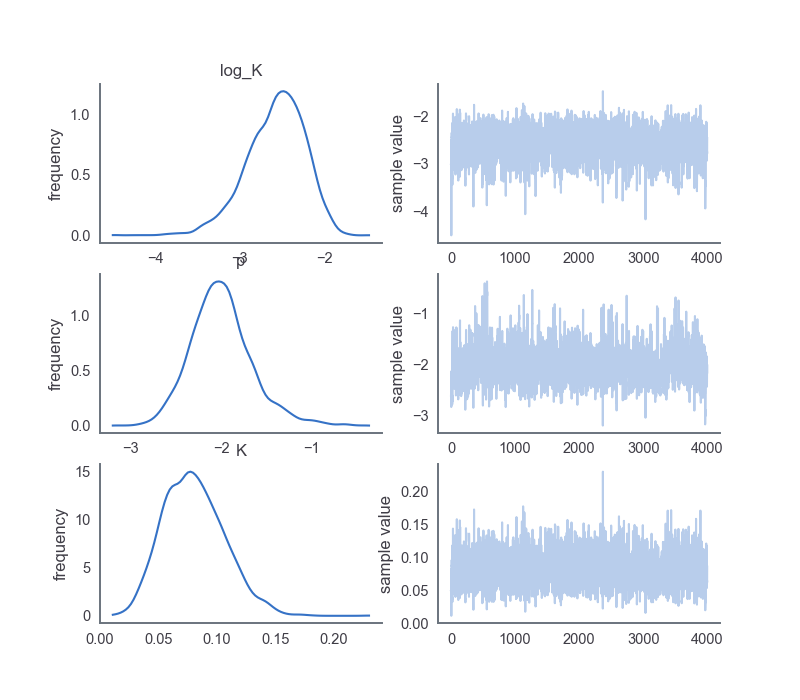

In [155]:
fit.plot();


In [174]:
fit_model =  stan_utility.compile_model(filename='fit_chi2.stan', model_name='chi2_fit' )

def analyze_simu(simu):
    
    
    # Fit the simulated observation
    binner = Rebinner(simu,10)
    rebinned_counts = binner.rebin(simu)[0]
    new_a, new_b = binner.get_new_start_and_stop(a,b)
    
    print(binner.n_bins)
    
    input_data = dict(N=binner.n_bins,
                      a=new_a,
                      b=new_b,
                      counts =rebinned_counts,
                      x0=x0)
    
    fit = fit_model.sampling(data=input_data, seed=4938483, n_jobs=1)
    
    # Compute diagnostics
    warning_code = stan_utility.check_all_diagnostics(fit, quiet=True)
    
    # Compute rank of prior draw with respect to thinned posterior draws
    thinned_p = fit.extract()['p'][np.arange(0, 4000 - 7, 8)]
    sbc_rank = len(list(filter(lambda x: x > simu_p, thinned_p)))
    
    # Compute posterior sensitivities
    summary = fit.summary(probs=[0.5],pars='p')
    post_mean_p = [x[0] for x in summary['summary']][0]
    post_sd_p = [x[2] for x in summary['summary']][0]
    
    prior_sd_p = 1.
    
    z_score = (post_mean_p - simu_p) / post_sd_p
    shrinkage = 1 - (post_sd_p / prior_sd_p)**2
    
    return [warning_code, sbc_rank, z_score, shrinkage]

INFO:pystan:COMPILING THE C++ CODE FOR MODEL chi2_fit_818ffb8e9bda620bb3d83e2097deecf4 NOW.


In [175]:
pool = multiprocessing.Pool(4)
ensemble_output = pool.map(analyze_simu, sim_counts)

8
8
8
8
8
8
8
9
8
9
9
9
10
9
11
9
9
9
9
6
8
10
8
9
9
11
9
9
10
8
8
9
9
7
7
8
10
9
8
9
7
8
9
9
8
8
10
9
9
8
10
8
8
10
9
8
8
10
9
8
9
8
10
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
8
9
9
9
9
9
9
8
9
7
10
8
9
9
10
9
8
9
9
10
9
10
10
9
9
8
9
9
8
7
8
9
8
11
9
9
8
10
9
8
9
9
10
8
10
9
10
9
8
8
8
8
8
8
9
8
9
9
8
8
7
10
8
9
8
9
9
9
9
8
9
10
9
9
9
8
9
8
10
9
8
8
9
8
8
9
8
9
8
11
8
8
9


RuntimeError: Initialization failed.

Process ForkPoolWorker-132:
Process ForkPoolWorker-130:
Process ForkPoolWorker-129:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process Fork

# With background

In [4]:
gen_bkg = stan_utility.compile_model(filename='generate_data_bkg.stan', model_name='poisson_gen_bkg' )

Using cached StanModel


In [17]:
nbins = 100;
bins = np.logspace(0,2, nbins +1)
a = bins[:-1]
b = bins[1:]

simu_K = 1.
simu_p =-2

simu_K_bkg = 2.
simu_p_bkg =-1.2
x0 = 10.

gen_data = dict(N=nbins, a=a,b=b,K=simu_K,p=simu_p,K_bkg=simu_K_bkg,p_bkg=simu_p_bkg,x0=x0)

R = 10000 # 1000 draws from the Bayesian joint distribution

out = gen_bkg.sampling(data=gen_data,
                 
                   iter=R, warmup=0, chains=1, refresh=R,
                     seed=4838282, algorithm="Fixed_param"
                   
                  
                  )


sim_obs= out.extract('observation')['observation'].astype(int)
sim_bkg= out.extract('background')['background'].astype(int)

<IPython.core.display.Javascript object>


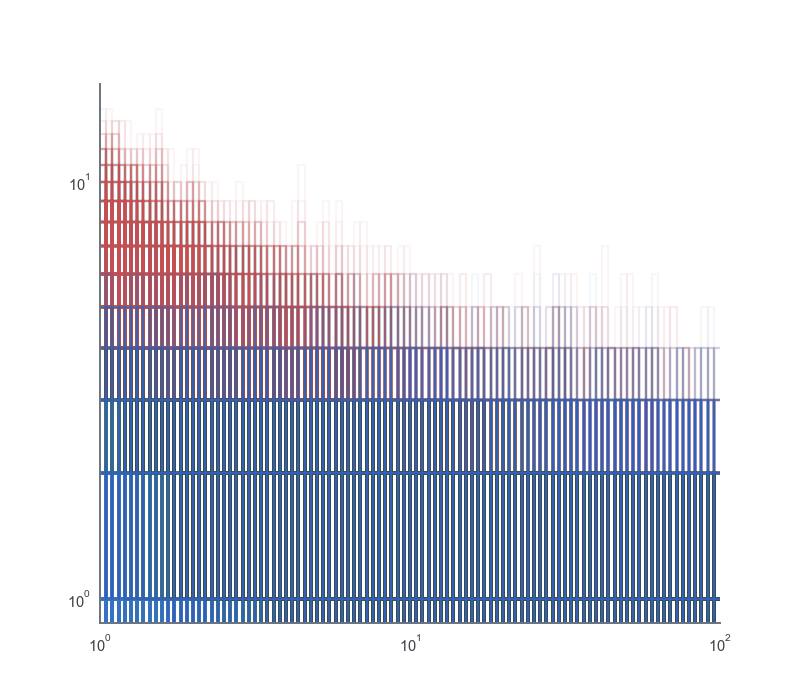

(1, 100)

In [18]:
fig, ax = plt.subplots()

for c in sim_obs[::10]:

    step_plot(np.vstack((a,b)).T, c, ax, fill=False, fill_min=0, alpha=.05, color='r')
    
    
for c in sim_bkg[::10]:

    step_plot(np.vstack((a,b)).T, c, ax, fill=False, fill_min=0, alpha=.05, color='b')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,100)

# Background subtraction

In [19]:
sub_counts = sim_obs - sim_bkg
model_chi = stan_utility.compile_model(filename='fit_chi2.stan', model_name='chi2_fit' )

Using cached StanModel


In [20]:
def init_me():
    
    return dict(log_K=0,p=-2)

def mle_chi_go(counts):
    
    idx = counts < 0
    counts[idx] == 0
    
    binner = Rebinner(counts,10)
    rebinned_counts = binner.rebin(counts)[0]
    new_a, new_b = binner.get_new_start_and_stop(a,b)
    
    data = dict(N=binner.n_bins, a=new_a,b=new_b, counts =rebinned_counts,  x0=x0)
    #print(binner.n_bins)
    try:
        fit = model_chi.optimizing(data=data, seed=345766723, init=init_me)
    
        return fit['K'], fit['p']
    
    except:
        
        return -99, -99

In [21]:
model = stan_utility.compile_model(filename='fit_poisson_background.stan', model_name='poisson_fit_bkg' )

def mle_go(data):
    
    
    obs, bkg = data.T
    
    
    
    in_data = dict(N=nbins, a=a,b=b, observation =obs, background=bkg,  x0=x0)
    fit = model.optimizing(data=in_data, seed=345766723)
    
    
    return fit['K'], fit['p']




Using cached StanModel


In [22]:
aa=np.array([sim_obs.T,sim_bkg.T]).T

In [23]:
pool = multiprocessing.Pool(4)
ensemble_output = np.array(pool.map(mle_go , aa))

pool.close()

In [24]:
pool = multiprocessing.Pool(4)
ensemble_output2 = np.array(pool.map(mle_chi_go , sub_counts))

pool.close()

<IPython.core.display.Javascript object>


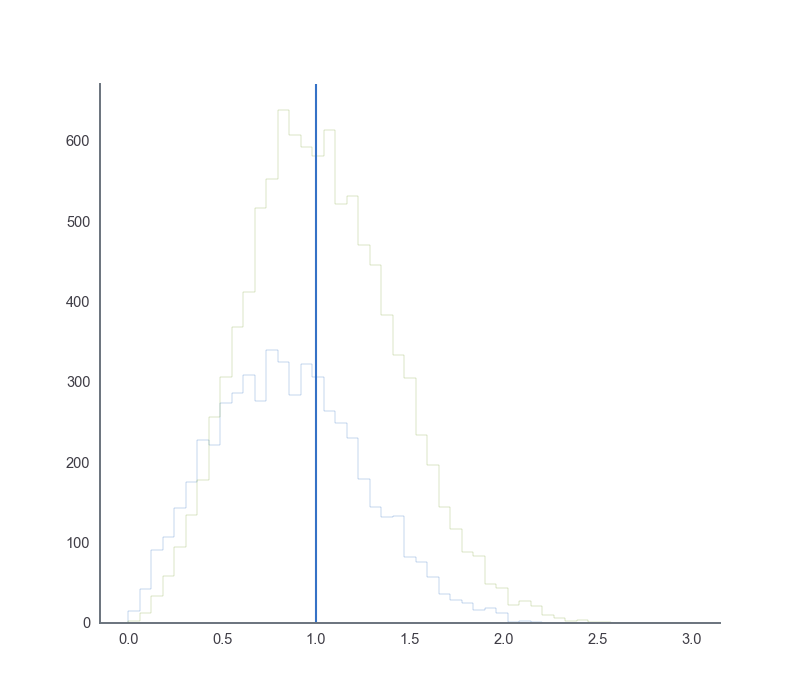

In [27]:
fig, ax = plt.subplots()

idx = ensemble_output2[:,0]==-99
bins = np.linspace(0.,3.,50)
ax.hist(ensemble_output2[~idx,0] ,bins=bins,histtype='step')
ax.hist(ensemble_output[:,0] ,bins=bins,histtype='step')

ax.axvline(1)

<IPython.core.display.Javascript object>


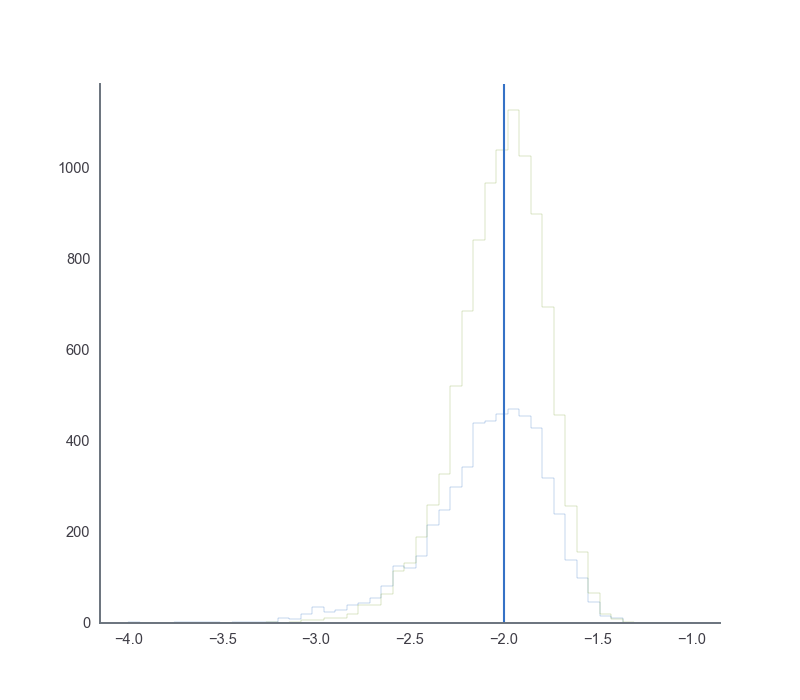

In [28]:
fig, ax = plt.subplots()

bins = np.linspace(-4.,-1.,50)

idx = ensemble_output2[:,1]==-99

ax.hist(ensemble_output2[~idx,1] ,bins=bins,histtype='step')
ax.hist(ensemble_output[:,1] ,bins=bins,histtype='step')

ax.axvline(-2)